In [2]:
!pip install gensim

  Found existing installation: Cython 0.29.6
    Uninstalling Cython-0.29.6:
      Successfully uninstalled Cython-0.29.6


In [3]:
import networkx as nx
import numpy as np
import os
import time
import pandas as pd
import matplotlib.pyplot as plt
from itertools import chain
from collections import defaultdict
from gensim.models import Word2Vec
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

A:\anaconda\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


# Pipeline

### Data Loader

We need to load networks into memory. Usually networks are organized as pairs of nodes. And sometimes different edges have different weights. Hence, we use networkx.DiGraph to store such structure information and attributes.

In [4]:
def load_data(file_name):
    """
    read edges from an edge file
    """
    edges = list()
    df = pd.read_csv(file_name)
    for idx, row in df.iterrows():
        user_id, friends = row["user_id"], eval(row["friends"])
        for friend in friends:
            # add each friend relation as an edge
            edges.append((user_id, friend))
    edges = sorted(edges)
    
    return edges

def load_test_data(file_name):
    """
    read edges from an edge file
    """
    edges = list()
    scores = list()
    df = pd.read_csv(file_name)
    for idx, row in df.iterrows():
        edges.append((row["src"], row["dst"]))
    edges = sorted(edges)
    
    return edges

def generate_false_edges(true_edges, num_false_edges=5):
    """
    generate false edges given true edges
    """
    nodes = list(set(chain.from_iterable(true_edges)))
    N = len(nodes)
    true_edges = set(true_edges)
    print(N, len(true_edges))
    false_edges = set()
    
    while len(false_edges) < num_false_edges:
        # randomly sample two different nodes and check whether the pair exisit or not
        src, dst = nodes[int(np.random.rand() * N)], nodes[int(np.random.rand() * N)]
        if src != dst and (src, dst) not in true_edges and (src, dst) not in false_edges:
            false_edges.add((src, dst))
    false_edges = sorted(false_edges)
    
    return false_edges

def construct_graph_from_edges(edges):
    """
    generate a directed graph object given true edges
    DiGraph documentation: https://networkx.github.io/documentation/stable/reference/classes/digraph.html
    """
    # convert a list of edges {(u, v)} to a list of edges with weights {(u, v, w)}
    edge_weight = defaultdict(float)
    for e in edges:
        edge_weight[e] += 1.0
    weighed_edge_list = list()
    for e in sorted(edge_weight.keys()):
        weighed_edge_list.append((e[0], e[1], edge_weight[e]))
        
    graph = nx.DiGraph()
    graph.add_weighted_edges_from(weighed_edge_list)
    
    print("number of nodes:", graph.number_of_nodes())
    print("number of edges:", graph.number_of_edges())
    
    return graph

### Random Walk Generator

Random walk generators or random walkers yield random walks that contain both local and higher-order neighborhood information. However, naive non-uniform sampling is very slow, which requires O(n) time complexity. Here alias sampling can reduce the time complexity to O(1) with O(n) space. If you are interested, please see the following blog.

In [5]:
def alias_setup(probs):
    """
    compute utility lists for non-uniform sampling from discrete distributions.
    details: https://lips.cs.princeton.edu/the-alias-method-efficient-sampling-with-many-discrete-outcomes/
    """
    K = len(probs)
    q = np.zeros(K)
    J = np.zeros(K, dtype=np.int)

    smaller = list()
    larger = list()
    for kk, prob in enumerate(probs):
        q[kk] = K * prob
        if q[kk] < 1.0:
            smaller.append(kk)
        else:
            larger.append(kk)

    while len(smaller) > 0 and len(larger) > 0:
        small = smaller.pop()
        large = larger.pop()

        J[small] = large
        q[large] = q[large] + q[small] - 1.0
        if q[large] < 1.0:
            smaller.append(large)
        else:
            larger.append(large)

    return J, q

def get_alias_node(graph, node):
    """
    get the alias node setup lists for a given node.
    """
    # get the unnormalized probabilities with the first-order information
    unnormalized_probs = list()
    for nbr in graph.neighbors(node):
        unnormalized_probs.append(graph[node][nbr]["weight"])
    unnormalized_probs = np.array(unnormalized_probs)
    if len(unnormalized_probs) > 0:
        normalized_probs = unnormalized_probs / unnormalized_probs.sum()
    else:
        normalized_probs = unnormalized_probs
        
    return alias_setup(normalized_probs)
    
def get_alias_edge(graph, src, dst, p=1, q=1):
    """
    get the alias edge setup lists for a given edge.
    """
    # get the unnormalized probabilities with the second-order information
    unnormalized_probs = list()
    for dst_nbr in graph.neighbors(dst):
        if dst_nbr == src: # distance is 0
            unnormalized_probs.append(graph[dst][dst_nbr]["weight"]/p)
        elif graph.has_edge(dst_nbr, src): # distance is 1
            unnormalized_probs.append(graph[dst][dst_nbr]["weight"])
        else: # distance is 2
            unnormalized_probs.append(graph[dst][dst_nbr]["weight"]/q)
    unnormalized_probs = np.array(unnormalized_probs)
    if len(unnormalized_probs) > 0:
        normalized_probs = unnormalized_probs / unnormalized_probs.sum()
    else:
        normalized_probs = unnormalized_probs

    return alias_setup(normalized_probs)

def preprocess_transition_probs(graph, p=1, q=1):
    """
    preprocess transition probabilities for guiding the random walks.
    """
    alias_nodes = dict()
    for node in graph.nodes():
        alias_nodes[node] = get_alias_node(graph, node)

    alias_edges = dict()
    for edge in graph.edges():
        alias_edges[edge] = get_alias_edge(graph, edge[0], edge[1], p=p, q=q)

    return alias_nodes, alias_edges

The difference between DeepWalk and node2vec is how to generate random walks. The former only consider the first-order information while the latter also involves the second-order information.

In [6]:
def alias_draw(J, q):
    """
    draw sample from a non-uniform discrete distribution using alias sampling.
    """
    K = len(J)

    kk = int(np.floor(np.random.rand() * K))
    if np.random.rand() < q[kk]:
        return kk
    else:
        return J[kk]


# helper function to generate the long random walk as desired
def fallback(walk, fetch_last_num=1):
    if len(walk) > fetch_last_num:
        walk.pop()
        fetched = []
        for i in range(fetch_last_num):
            fetched.append(walk[-1-i])
        return walk, fetched
    else:
        return [], [None for _ in range(fetch_last_num)]

def generate_first_order_random_walk(graph, alias_nodes, 
                                     walk_length=10, start_node=None, verbose=False, max_trails=10):
    """
    simulate a random walk starting from start node and considering the first order information.
    max_trials: set the max trials to be one for standard random walk. Larger max_trails will make the generated biased.
    """
    if start_node == None:
        start_node = np.random.choice(graph.nodes())
    walk = [start_node]
    cur = start_node
    num_tried = 0
    
    ########## begin ##########
    while len(walk) < walk_length:
        cur_nbrs = list(graph.neighbors(cur))
        if len(cur_nbrs) > 0: # if we can sample next nodes
            # sample the next node based on alias_nodes
            cur = cur_nbrs[alias_draw(*alias_nodes[cur])]
            walk.append(cur)
        else: # if we can't do that
            num_tried += 1
            if num_tried >= max_trails:
                break

            walk, fetched = fallback(walk, fetch_last_num=1)
            cur = fetched[0]
            if len(walk) == 0: # if falls back to the empty walk
                start_node = np.random.choice(graph.nodes())
                walk = [start_node]
                cur = start_node
    ########## end ##########

    if verbose: 
        print(f'walk of lenght {len(walk)} generated with {num_tried} trails')
    return walk
    
def generate_second_order_random_walk(graph, alias_nodes, alias_edges, 
                                      walk_length=10, start_node=None, verbose=False, max_trails=10):
    """
    simulate a random walk starting from start node and considering the second order information.
    """
    if start_node == None:
        start_node = np.random.choice(graph.nodes())
    walk = [start_node]
    
    prev = None
    cur = start_node
    num_tried = 0

    ########## begin ##########
    while len(walk) < walk_length:
        cur_nbrs = list(graph.neighbors(cur))
        if len(cur_nbrs) > 0:
            if prev is None:
                # sample the next node based on alias_nodes
                prev, cur = cur, cur_nbrs[alias_draw(*alias_nodes[cur])]
            else:
                # sample the next node based on alias_edges
                prev, cur = cur, cur_nbrs[alias_draw(*alias_edges[(prev, cur)])]
            walk.append(cur)
        else:
            num_tried += 1
            if num_tried >= max_trails:
                break
            walk, (cur, prev) = fallback(walk, fetch_last_num=2)
            if len(walk) == 0:
                start_node = np.random.choice(graph.nodes())
                walk = [start_node]
                cur = start_node
                prev = None
    ########## end ##########
    if verbose: 
        print(f'walk of lenght {len(walk)} generated with {num_tried} trails')
    return walk

### Network Embedding Algorithms

In [7]:
def build_deepwalk(graph, alias_nodes, node_dim=10, num_walks=10, walk_length=10):
    """
    build a deepwalk model
    """
    print("building a DeepWalk model...", end="\t")
    st = time.time()
    np.random.seed(0)
    nodes = list(graph.nodes())
    walks = list()
    # generate random walks
    for walk_iter in range(num_walks):
        np.random.shuffle(nodes)
        for node in nodes:
            walks.append(generate_first_order_random_walk(
                graph, alias_nodes, walk_length=walk_length, start_node=node))
        
    walk_lens = [len(w) for w in walks]
    if len(walk_lens) > 0:
        avg_walk_len = sum(walk_lens) / len(walk_lens)
    else:
        avg_walk_len = 0.0
    print("number of walks: %d\taverage walk length: %.4f" % (len(walks), avg_walk_len), end="\t")
    
    # train a skip-gram model for these walks
    model = Word2Vec(walks, vector_size=node_dim, window=3, min_count=0, sg=1, alpha=5e-3, workers=os.cpu_count(), epochs=50)
    print("training time: %.4f" % (time.time()-st))
    
    return model

def build_node2vec(graph, alias_nodes, alias_edges, node_dim=10, num_walks=10, walk_length=10):
    """
    build a node2vec model
    """
    print("building a node2vec model...", end="\t")
    st = time.time()
    np.random.seed(0)
    nodes = list(graph.nodes())
    walks = list()
    # generate random walks
    for walk_iter in range(num_walks):
        np.random.shuffle(nodes)
        for node in nodes:
            walks.append(generate_second_order_random_walk(
                graph, alias_nodes, alias_edges, walk_length=walk_length, start_node=node))
            
    walk_lens = [len(w) for w in walks]
    if len(walk_lens) > 0:
        avg_walk_len = sum(walk_lens) / len(walk_lens)
    else:
        avg_walk_len = 0.0    
    print("number of walks: %d\taverage walk length: %.4f" % (len(walks), avg_walk_len), end="\t")
    
    # train a skip-gram model for these walks
    model = Word2Vec(walks, vector_size=node_dim, window=3, alpha=5e-3, min_count=0, sg=1, workers=os.cpu_count(), epochs=50)
    print("training time: %.4f" % (time.time()-st))
    
    return model

### Scorer

In [8]:
def get_cosine_sim(model, u, v):
    """
    get the cosine similarity between two nodes
    """
    try:
        u = model.wv[u]
        v = model.wv[v]
        return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))
    except:
        return 0.5

def get_auc_score(model, true_edges, false_edges):
    """
    get the auc score
    """
    y_true = [1] * len(true_edges) + [0] * len(false_edges)
    
    y_score = list()
    for e in true_edges:
        y_score.append(get_cosine_sim(model, e[0], e[1]))
    for e in false_edges:
        y_score.append(get_cosine_sim(model, e[0], e[1]))
    
    return roc_auc_score(y_true, y_score)

def write_pred(file_name, edges, scores):
    df = pd.DataFrame()
    df["src"] = [e[0] for e in edges]
    df["dst"] = [e[1] for e in edges]
    df["score"] = scores
    df.to_csv(file_name, index=False)
    
    



def write_valid_ans(file_name, edges, scores):
    df = pd.DataFrame()
    df["src"] = [e[0] for e in edges]
    df["dst"] = [e[1] for e in edges]
    df["score"] = scores
    df.to_csv(file_name, index=False)

### Try them over a Real-life Network

Firstly, we need to load edges into memory and use the networkx.DiGraph structure to store the graph.

In [9]:
train_file = "data/train.csv"
valid_file = "data/valid.csv"
test_file = "data/test.csv"

np.random.seed(0)
train_edges = load_data(train_file)
graph = construct_graph_from_edges(train_edges)
valid_edges = load_data(valid_file)
false_edges = generate_false_edges(train_edges+valid_edges, 40000-len(valid_edges))
test_edges = load_test_data(test_file)

number of nodes: 8328
number of edges: 100000
8474 119268


After that, we can use preprocess transition probabilities with the help of alias sampling.

In [10]:
alias_nodes, alias_edges = preprocess_transition_probs(graph, p=1, q=1)

A:\anaconda\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


We can use random walk generators to generate random walks.

Let's try to generate a first-order random walk and a second-order random walk.

In [11]:
generate_first_order_random_walk(graph, alias_nodes=alias_nodes,
                                 start_node="N6ZTMIue-2b30CJv2tyPGg", walk_length=10)

['N6ZTMIue-2b30CJv2tyPGg',
 'cvAPwZRWaDxSUudy8CR3Rw',
 '9E35LB29RXJixo0563Iwew',
 'Sxkag2soHkimplexM7eOBA',
 'HUX1p0y71x_j-5VWz4tB0w',
 'yWfbvo0LXhssOsH9FNJ8Jw',
 'M-xJMhi-HphpWaD2992K3A',
 'kOPRX94rDBXEPmLBZNG7RQ',
 'zg7PG_AEaCupikuKVVM_4w',
 'deL6e_z9xqZTIODKqnvRXQ']

In [12]:
generate_second_order_random_walk(graph, alias_nodes=alias_nodes, alias_edges=alias_edges,
                                  start_node="N6ZTMIue-2b30CJv2tyPGg", walk_length=10)

['N6ZTMIue-2b30CJv2tyPGg',
 'u0aFzHN2GzAq2czVKcDmqg',
 'N6ZTMIue-2b30CJv2tyPGg',
 'cvAPwZRWaDxSUudy8CR3Rw',
 '9E35LB29RXJixo0563Iwew',
 'V74paj6Zok4DvGnciFEZMg',
 'hiEQhuyMOSKCvVqmHrpvhg',
 'V74paj6Zok4DvGnciFEZMg',
 'rmw8xK8XEmo9yPPrIRbO5Q',
 'tm-O-2D0mRt2mSwo6odOZw']

And we can build a DeepWalk model and a node2vec model. Here we set p=q=0.5 so that the walker will not go very far away from the start node.

In [13]:
model = build_deepwalk(graph, alias_nodes, node_dim=10, num_walks=10, walk_length=10)

building a DeepWalk model...	number of walks: 83280	average walk length: 9.8980	training time: 39.3891


In [14]:
model = build_node2vec(graph, alias_nodes, alias_edges, node_dim=10, num_walks=10, walk_length=10)

building a node2vec model...	number of walks: 83280	average walk length: 9.9910	training time: 42.8601


Let's see the node embeddings of three nodes, and cosine similarities of two edges.

In [15]:
print("node embedding (\"N6ZTMIue-2b30CJv2tyPGg\"):",
      model.wv["N6ZTMIue-2b30CJv2tyPGg"])
print("node embedding (\"N7E-CfqdME28dakWdEKNvw\"):",
      model.wv["N7E-CfqdME28dakWdEKNvw"])
print("node embedding (\"MmlJSLDg-IFaeXb5wdJbgg\"):",
      model.wv.vectors[model.wv.index_to_key.index("MmlJSLDg-IFaeXb5wdJbgg")])
print("true edge (\"N6ZTMIue-2b30CJv2tyPGg\", \"N7E-CfqdME28dakWdEKNvw\"):",
      get_cosine_sim(model, "N6ZTMIue-2b30CJv2tyPGg", "N7E-CfqdME28dakWdEKNvw"))
print("false edge (\"N6ZTMIue-2b30CJv2tyPGg\", \"MmlJSLDg-IFaeXb5wdJbgg\"):",
      get_cosine_sim(model, "N6ZTMIue-2b30CJv2tyPGg", "MmlJSLDg-IFaeXb5wdJbgg"))

node embedding ("N6ZTMIue-2b30CJv2tyPGg"): [ 0.24803354 -0.593051    1.8624067   1.6588436  -0.5182542   1.2396073
  0.94407755  0.2611696  -0.9476495  -0.6131832 ]
node embedding ("N7E-CfqdME28dakWdEKNvw"): [ 0.6857334  -0.35252628  1.6041577   1.0032114  -0.08637963  0.5126933
  1.6949996   0.17708418 -0.08922548 -1.1403564 ]
node embedding ("MmlJSLDg-IFaeXb5wdJbgg"): [ 1.0178009  -0.14174612 -1.2785282   0.19165833  1.9472897   1.5566844
  2.2345169   1.2264185  -0.9147093  -2.0809708 ]
true edge ("N6ZTMIue-2b30CJv2tyPGg", "N7E-CfqdME28dakWdEKNvw"): 0.8469985
false edge ("N6ZTMIue-2b30CJv2tyPGg", "MmlJSLDg-IFaeXb5wdJbgg"): 0.25398138


# Link Prediction

We can train the model with different parameters and test the model on the validation set. Please show your parameter search process and analysis in your code, and visualization tools (Heatmap, etc.) are recommended to make your analysis clear.

### deepwalk

In [16]:
np.random.seed(0)

node_dim = 12
num_walks = 26
walk_length = 12

deepwalk_auc_scores = dict()


for walk_length in [10, 12, 14]:
    for num_walks in [26 ,28]:
        print("node dim: %d,\tnum_walks: %d,\twalk_length: %d" % (node_dim, num_walks, walk_length), end="\t")
        model = build_deepwalk(graph, alias_nodes, 
                               node_dim=node_dim, num_walks=num_walks, walk_length=walk_length)
        deepwalk_auc_scores[(node_dim, num_walks, walk_length)] = get_auc_score(model, valid_edges, false_edges)
        print("auc: %.4f" % (deepwalk_auc_scores[(node_dim, num_walks, walk_length)]))

node dim: 12,	num_walks: 26,	walk_length: 10	building a DeepWalk model...	number of walks: 216528	average walk length: 9.8981	training time: 95.7287
auc: 0.9357
node dim: 12,	num_walks: 28,	walk_length: 10	building a DeepWalk model...	number of walks: 233184	average walk length: 9.8981	training time: 100.0238
auc: 0.9355
node dim: 12,	num_walks: 26,	walk_length: 12	building a DeepWalk model...	number of walks: 216528	average walk length: 11.8711	training time: 109.3807
auc: 0.9371
node dim: 12,	num_walks: 28,	walk_length: 12	building a DeepWalk model...	number of walks: 233184	average walk length: 11.8713	training time: 116.4785
auc: 0.9374
node dim: 12,	num_walks: 26,	walk_length: 14	building a DeepWalk model...	number of walks: 216528	average walk length: 13.8452	training time: 123.9927
auc: 0.9368
node dim: 12,	num_walks: 28,	walk_length: 14	building a DeepWalk model...	number of walks: 233184	average walk length: 13.8452	training time: 135.6844
auc: 0.9371


Text(0, 0.5, 'num_walks')

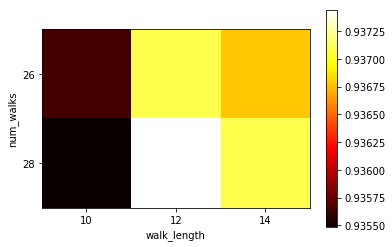

In [17]:
plt.figure(figsize=(6, 4))
node_dim = 12
# you should have an auc score dictionary here.
a = np.array([[deepwalk_auc_scores[(node_dim, num_walks, walk_length)] for walk_length in [10, 12, 14]] for num_walks in [26 ,28]])
plt.imshow(a, cmap="hot", interpolation="nearest")
plt.colorbar()
plt.xticks(ticks=[0,1,2], labels=[10, 12, 14])
plt.xlabel("walk_length")
plt.yticks(ticks=[0,1], labels=[26 ,28])
plt.ylabel("num_walks")

### node2vector

In [18]:
np.random.seed(0)

node_dim = 12
num_walks = 28
walk_length = 12
p = 0.25
q = 4

node2vec_auc_scores = dict()

for walk_length in [10, 12, 14]:
    for num_walks in [26 ,28]:
        print("node dim: %d,\tnum_walks: %d,\twalk_length: %d,\tp: %.2f,\tq: %.2f" % (
            node_dim, num_walks, walk_length, p, q), end="\t")
        alias_nodes, alias_edges = preprocess_transition_probs(graph, p=p, q=q)
        model = build_node2vec(graph, alias_nodes, alias_edges, 
                               node_dim=node_dim, num_walks=num_walks, walk_length=walk_length)
        node2vec_auc_scores[(node_dim, num_walks, walk_length, p, q)] = get_auc_score(model, valid_edges, false_edges)
        print("auc: %.4f" % (node2vec_auc_scores[(node_dim, num_walks, walk_length, p, q)]))

node dim: 12,	num_walks: 26,	walk_length: 10,	p: 0.25,	q: 4.00	

A:\anaconda\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


building a node2vec model...	number of walks: 216528	average walk length: 9.9930	training time: 98.2124
auc: 0.9351
node dim: 12,	num_walks: 28,	walk_length: 10,	p: 0.25,	q: 4.00	building a node2vec model...	number of walks: 233184	average walk length: 9.9930	training time: 106.7275
auc: 0.9353
node dim: 12,	num_walks: 26,	walk_length: 12,	p: 0.25,	q: 4.00	building a node2vec model...	number of walks: 216528	average walk length: 11.9909	training time: 113.1200
auc: 0.9366
node dim: 12,	num_walks: 28,	walk_length: 12,	p: 0.25,	q: 4.00	building a node2vec model...	number of walks: 233184	average walk length: 11.9909	training time: 138.4413
auc: 0.9356
node dim: 12,	num_walks: 26,	walk_length: 14,	p: 0.25,	q: 4.00	building a node2vec model...	number of walks: 216528	average walk length: 13.9884	training time: 138.6772
auc: 0.9359
node dim: 12,	num_walks: 28,	walk_length: 14,	p: 0.25,	q: 4.00	building a node2vec model...	number of walks: 233184	average walk length: 13.9883	training time: 1

Text(0, 0.5, 'num_walks')

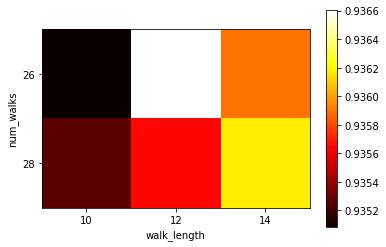

In [19]:
plt.figure(figsize=(6, 4))
node_dim = 12
p=0.25
q=4.00
# you should have an auc score dictionary here.
a = np.array([[node2vec_auc_scores[(node_dim, num_walks, walk_length, p, q)] for walk_length in [10, 12, 14]] for num_walks in [26 ,28]])
plt.imshow(a, cmap="hot", interpolation="nearest")
plt.colorbar()
plt.xticks(ticks=[0,1,2], labels=[10, 12, 14])
plt.xlabel("walk_length")
plt.yticks(ticks=[0,1], labels=[26 ,28])
plt.ylabel("num_walks")

### Tuning p, q 

In [20]:
np.random.seed(0)

node_dim = 12
num_walks = 28
walk_length = 10
#         p = 0.25
#         q = 4

node2vec_auc_scores = dict()

for p in [0.23, 0.24, 0.25]:
    for q in [3.95, 4, 4.05]:
        print("node dim: %d,\tnum_walks: %d,\twalk_length: %d,\tp: %.2f,\tq: %.2f" % (
            node_dim, num_walks, walk_length, p, q), end="\t")
        alias_nodes, alias_edges = preprocess_transition_probs(graph, p=p, q=q)
        model = build_node2vec(graph, alias_nodes, alias_edges, 
                               node_dim=node_dim, num_walks=num_walks, walk_length=walk_length)
        node2vec_auc_scores[(node_dim, num_walks, walk_length, p, q)] = get_auc_score(model, valid_edges, false_edges)
        print("auc: %.4f" % (node2vec_auc_scores[(node_dim, num_walks, walk_length, p, q)]))

node dim: 12,	num_walks: 28,	walk_length: 10,	p: 0.23,	q: 3.95	

A:\anaconda\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


building a node2vec model...	number of walks: 233184	average walk length: 9.9930	training time: 112.2967
auc: 0.9353
node dim: 12,	num_walks: 28,	walk_length: 10,	p: 0.23,	q: 4.00	building a node2vec model...	number of walks: 233184	average walk length: 9.9930	training time: 108.1458
auc: 0.9343
node dim: 12,	num_walks: 28,	walk_length: 10,	p: 0.23,	q: 4.05	building a node2vec model...	number of walks: 233184	average walk length: 9.9927	training time: 105.8383
auc: 0.9340
node dim: 12,	num_walks: 28,	walk_length: 10,	p: 0.24,	q: 3.95	building a node2vec model...	number of walks: 233184	average walk length: 9.9930	training time: 105.3875
auc: 0.9356
node dim: 12,	num_walks: 28,	walk_length: 10,	p: 0.24,	q: 4.00	building a node2vec model...	number of walks: 233184	average walk length: 9.9933	training time: 105.5622
auc: 0.9357
node dim: 12,	num_walks: 28,	walk_length: 10,	p: 0.24,	q: 4.05	building a node2vec model...	number of walks: 233184	average walk length: 9.9930	training time: 105.

Text(0, 0.5, 'num_walks')

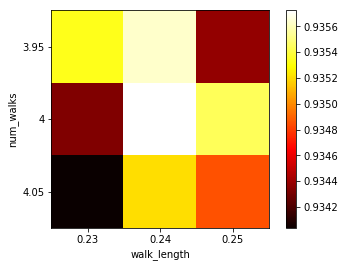

In [21]:
plt.figure(figsize=(6, 4))
node_dim = 12
num_walks=28
walk_length=10
# you should have an auc score dictionary here.
a = np.array([[node2vec_auc_scores[(node_dim, num_walks, walk_length, p, q)] for p in [0.23, 0.24, 0.25]] for q in [3.95, 4, 4.05]])
plt.imshow(a, cmap="hot", interpolation="nearest")
plt.colorbar()
plt.xticks(ticks=[0,1,2], labels=[0.23, 0.24, 0.25])
plt.xlabel("walk_length")
plt.yticks(ticks=[0,1,2], labels=[3.95, 4, 4.05])
plt.ylabel("num_walks")

### Exchange domain of parameter searching domain

In [22]:
np.random.seed(0)

node_dim = 12
num_walks = 28
walk_length = 10
#         p = 0.25
#         q = 4

node2vec_auc_scores_2 = dict()

for q in [0.23, 0.24, 0.25]:
    for p in [3.95, 4, 4.05]:
        print("node dim: %d,\tnum_walks: %d,\twalk_length: %d,\tp: %.2f,\tq: %.2f" % (
            node_dim, num_walks, walk_length, p, q), end="\t")
        alias_nodes, alias_edges = preprocess_transition_probs(graph, p=p, q=q)
        model = build_node2vec(graph, alias_nodes, alias_edges, 
                               node_dim=node_dim, num_walks=num_walks, walk_length=walk_length)
        node2vec_auc_scores_2[(node_dim, num_walks, walk_length, p, q)] = get_auc_score(model, valid_edges, false_edges)
        print("auc: %.4f" % (node2vec_auc_scores_2[(node_dim, num_walks, walk_length, p, q)]))

node dim: 12,	num_walks: 28,	walk_length: 10,	p: 3.95,	q: 0.23	

A:\anaconda\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


building a node2vec model...	number of walks: 233184	average walk length: 9.9767	training time: 108.6935
auc: 0.9323
node dim: 12,	num_walks: 28,	walk_length: 10,	p: 4.00,	q: 0.23	building a node2vec model...	number of walks: 233184	average walk length: 9.9779	training time: 110.9143
auc: 0.9327
node dim: 12,	num_walks: 28,	walk_length: 10,	p: 4.05,	q: 0.23	building a node2vec model...	number of walks: 233184	average walk length: 9.9773	training time: 111.2222
auc: 0.9326
node dim: 12,	num_walks: 28,	walk_length: 10,	p: 3.95,	q: 0.24	building a node2vec model...	number of walks: 233184	average walk length: 9.9769	training time: 108.5519
auc: 0.9330
node dim: 12,	num_walks: 28,	walk_length: 10,	p: 4.00,	q: 0.24	building a node2vec model...	number of walks: 233184	average walk length: 9.9766	training time: 108.3056
auc: 0.9327
node dim: 12,	num_walks: 28,	walk_length: 10,	p: 4.05,	q: 0.24	building a node2vec model...	number of walks: 233184	average walk length: 9.9772	training time: 108.

Text(0, 0.5, 'num_walks')

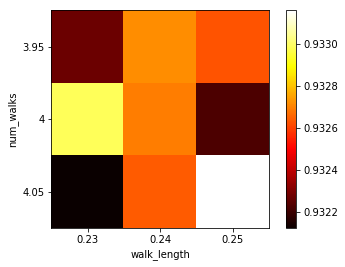

In [23]:
plt.figure(figsize=(6, 4))
node_dim = 12
num_walks=28
walk_length=10
# you should have an auc score dictionary here.
a = np.array([[node2vec_auc_scores_2[(node_dim, num_walks, walk_length, p, q)] for p in [3.95, 4, 4.05]] for q in [0.23, 0.24, 0.25]])
plt.imshow(a, cmap="hot", interpolation="nearest")
plt.colorbar()
plt.xticks(ticks=[0,1,2], labels=[0.23, 0.24, 0.25])
plt.xlabel("walk_length")
plt.yticks(ticks=[0,1,2], labels=[3.95, 4, 4.05])
plt.ylabel("num_walks")

### More tuning on hyperparameter

In [26]:
np.random.seed(0)

node_dim = 12
num_walks = 28
walk_length = 10
#         p = 0.25
#         q = 4

node2vec_auc_scores_3 = dict()

for p in [0.18, 0.28, 0.38]:
    for q in [3.6, 4, 4.4, 4.8]:
        print("node dim: %d,\tnum_walks: %d,\twalk_length: %d,\tp: %.2f,\tq: %.2f" % (
            node_dim, num_walks, walk_length, p, q), end="\t")
        alias_nodes, alias_edges = preprocess_transition_probs(graph, p=p, q=q)
        model = build_node2vec(graph, alias_nodes, alias_edges, 
                               node_dim=node_dim, num_walks=num_walks, walk_length=walk_length)
        node2vec_auc_scores_3[(node_dim, num_walks, walk_length, p, q)] = get_auc_score(model, valid_edges, false_edges)
        print("auc: %.4f" % (node2vec_auc_scores_3[(node_dim, num_walks, walk_length, p, q)]))

node dim: 12,	num_walks: 28,	walk_length: 10,	p: 0.18,	q: 3.60	

A:\anaconda\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


building a node2vec model...	number of walks: 233184	average walk length: 9.9933	training time: 103.7845
auc: 0.9343
node dim: 12,	num_walks: 28,	walk_length: 10,	p: 0.18,	q: 4.00	building a node2vec model...	number of walks: 233184	average walk length: 9.9927	training time: 104.2376
auc: 0.9349
node dim: 12,	num_walks: 28,	walk_length: 10,	p: 0.18,	q: 4.40	building a node2vec model...	number of walks: 233184	average walk length: 9.9935	training time: 104.3789
auc: 0.9333
node dim: 12,	num_walks: 28,	walk_length: 10,	p: 0.18,	q: 4.80	building a node2vec model...	number of walks: 233184	average walk length: 9.9937	training time: 104.6132
auc: 0.9350
node dim: 12,	num_walks: 28,	walk_length: 10,	p: 0.28,	q: 3.60	building a node2vec model...	number of walks: 233184	average walk length: 9.9933	training time: 105.4266
auc: 0.9347
node dim: 12,	num_walks: 28,	walk_length: 10,	p: 0.28,	q: 4.00	building a node2vec model...	number of walks: 233184	average walk length: 9.9932	training time: 105.

Text(0, 0.5, 'num_walks')

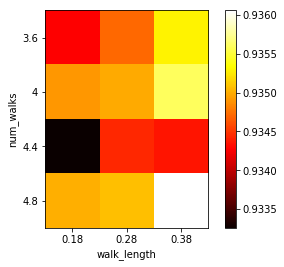

In [30]:
plt.figure(figsize=(6, 4))
node_dim = 12
num_walks=28
walk_length=10
# you should have an auc score dictionary here.
a = np.array([[node2vec_auc_scores_3[(node_dim, num_walks, walk_length, p, q)] for p in [0.18, 0.28, 0.38]] for q in [3.6, 4, 4.4, 4.8]])
plt.imshow(a, cmap="hot", interpolation="nearest")
plt.colorbar()
plt.xticks(ticks=[0,1,2], labels= [0.18, 0.28, 0.38])
plt.xlabel("walk_length")
plt.yticks(ticks=[0,1,2,3], labels=[3.6, 4, 4.4, 4.8])
plt.ylabel("num_walks")

Example of using Heatmap to viualize the result.

You can build model with the best parameters you find and save the prediction here.

In [ ]:
model = build_deepwalk(graph, alias_nodes, node_dim=10, num_walks=10, walk_length=10)
scores = [get_cosine_sim(model, src, dst) for src, dst in test_edges]
write_pred("data/pred.csv", test_edges, scores)

With the help of p and q, the node2vec model can fit training data better. And you can have a try if you set p=q=1, the two models will return the same results.